In [12]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from tqdm.notebook import tqdm 

In [13]:
df = pd.read_parquet('train.parquet')

In [14]:
data = pd.read_csv('train.csv', index_col='id', parse_dates=['date'])
data2 = data.loc[data['store_nbr'] == 1, ['date', 'family', 'sales', 'onpromotion']]

In [16]:
dec25 = []

for year in range(2013, 2017):
    for family in data2["family"].unique():
        dec25 += [
            {
                "date": pd.Timestamp(f"{year}-12-25"),
                "family": family,
                "sales": np.nan,
                "onpromotion": np.nan,
            }
        ]

data2 = pd.concat([data2, pd.DataFrame(dec25)], ignore_index=True).sort_values("date")
data2 = data2.rename(columns={"date": "ds", "sales": "y"})

In [ ]:
holidays_df = pd.read_csv('holidays_events.csv')

In [18]:
holidays_df = holidays_df.loc[holidays_df['locale'] == 'National', ['date','description']]

In [19]:
holidays_df['lower_window'] = 0 
holidays_df['upper_window'] = 0 

holidays_df = holidays_df.rename(columns={
    'date':'ds', 
    'description': 'holiday'
})

In [20]:
train = data2.loc[data2["ds"] < "2017-01-01"]
valid = data2.loc[(data2["ds"] >= "2017-01-01") & (data2["ds"] < "2017-04-01")]

In [ ]:
p = []

for family in tqdm(train["family"].unique()):
    print("family", family)
    train_ = train.loc[train["family"] == family]
    valid_ = valid.loc[valid["family"] == family]

    m = Prophet(
        seasonality_mode="additive",
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        holidays=holidays_df,
    )
    m.add_regressor("onpromotion")
    m.fit(train_)

    future = m.make_future_dataframe(periods=90, include_history=False)

    future = future.merge(valid_[["ds", "onpromotion"]], on="ds", how="left")

    forecast = m.predict(future)
    forecast["family"] = family
    p.append(forecast[["ds", "yhat", "family"]])

In [22]:
p = pd.concat(p, ignore_index=True)


In [23]:
p['yhat'] = p['yhat'].clip(lower=0)

In [24]:
p = p.merge(valid, on=['ds','family'], how='left')

In [25]:
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error

In [26]:
root_mean_squared_log_error(p['y'], p['yhat'])

0.534196513069908

In [27]:
root_mean_squared_error(p['y'], p['yhat'])

177.6455768765945

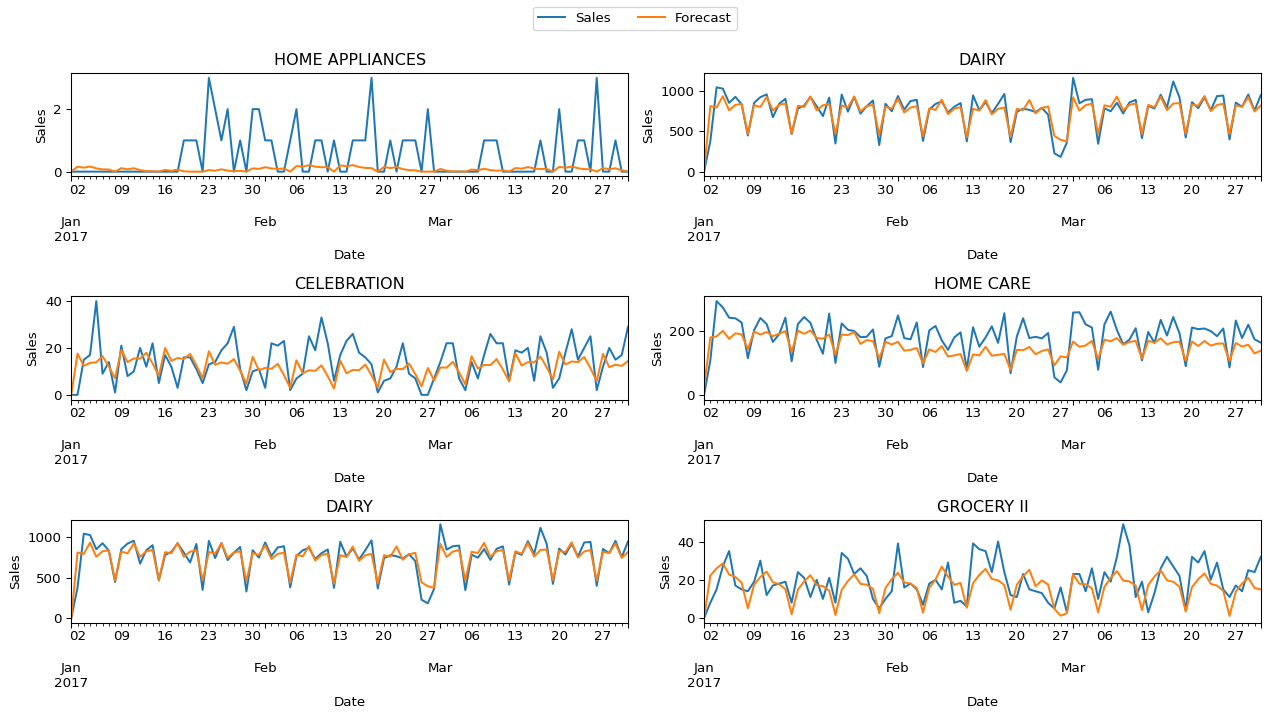

In [28]:
fig, ax = plt.subplots(3, 2,  figsize=(1280/96, 720/96), dpi=96)
ax = ax.flatten()

for ax_, family in enumerate(np.random.choice(p["family"].unique(), 6)):
    p_ = p.loc[p["family"] == family]
    p_.plot(x="ds", y="y", ax=ax[ax_], label="Sales")
    p_.plot(x="ds", y="yhat", ax=ax[ax_], label="Forecast")

    ax[ax_].set_xlabel("Date")
    ax[ax_].set_ylabel("Sales")
    ax[ax_].set_title(family)


for a in ax:
    a.legend_.remove()

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)

fig.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend


plt.show()

In [29]:
from joblib import Parallel, delayed 

In [33]:
def run_train(train_, valid_, family): 

    m = Prophet(
        seasonality_mode="additive",
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        holidays=holidays_df,
    )
    m.add_regressor("onpromotion")
    m.fit(train_)

    future = m.make_future_dataframe(periods=90, include_history=False)

    future = future.merge(valid_[['ds', 'onpromotion']], on = 'ds', how = 'left') 

    forecast = m.predict(future) 
    forecast['family'] = family 
    return forecast[['ds','yhat','family']]


In [34]:

jobs = []
for family in tqdm(train["family"].unique()):
    train_ = train.loc[train["family"] == family]
    valid_ = valid.loc[valid["family"] == family]
    jobs.append(
        delayed(run_train)(train_, valid_, family)
    )

  0%|          | 0/33 [00:00<?, ?it/s]

In [37]:
p = Parallel(n_jobs=-1, verbose=10, batch_size=32)(jobs) 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of  33 | elapsed:    2.8s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  10 out of  33 | elapsed:    3.0s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  14 out of  33 | elapsed:    3.2s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  18 out of  33 | elapsed:    3.3s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  22 out of  33 | elapsed:    3.3s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  26 out of  33 | elapsed:    3.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    3.5s finished
